#  GrAtSiD (in development)

Gratsid is contained now in one module:
"gratsid.py"

If you run:

from gratsid import *

then you will have all the gratsid functions ready to be run in your script.


The code is written to run using tensorflow 2 with GPU.  But if no GPU is available, it will run on the CPU.

If you find bugs, please report these back to me, I will get to work fixing them.

Most notable features of this version are:

- The sampling interval of the data ('Fs') can be specified.
- Associated data errors can be used in the inversions (although this slows down the algorithm)
- Seasonal oscillations are optional in the model
- User can allow (or not allow) different types of transients in the model.  The types of transients are multi-         transients, rooted polynomials (polynomials of nth order that have magnitude zero before and during the onset time), and         Heaviside step functions.  More transient types to be added in future development.
- The polynomial in the permanent basis functions can be of nth order (default is linear trajectory, i.e. 1st order)
- The function automatically notices the spatial dimension of the trajectory from the number of input columns.  Therefore, there is no need to use different versions of the GrAtSiD code (previously there were 1D, 2D, 3D versions)



## Importing the required modules

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np ### We will read-in data using numpy
import matplotlib.pyplot as plt  ### We are going to plot the results in this notebook
## The "magic" line below allows for plot inspection in Jupyter Notebook
%matplotlib nbagg  
from gratsid import *
import datetime as dt   ### We want to read in some dates from the data

## Loading in some data for this example notebook

In [2]:
data = np.loadtxt('./example_data/IQQE.txt')  ## yr, mo, da, E, N, U, sigE, sigN, sigU
known_steps_in = np.loadtxt('./example_data/IQQE_yrmoda_frac.txt')

## Getting the time vector (x) from the 3 date columns

In [3]:
## Function for making the dates into a python "datenum"
gen_jjj = np.vectorize(lambda x,y,z: dt.date.toordinal(dt.date(x,y,z)))
x = gen_jjj(data[:,0].astype(int),data[:,1].astype(int),data[:,2].astype(int))

## Taking a quick look at the time series

<IPython.core.display.Javascript object>


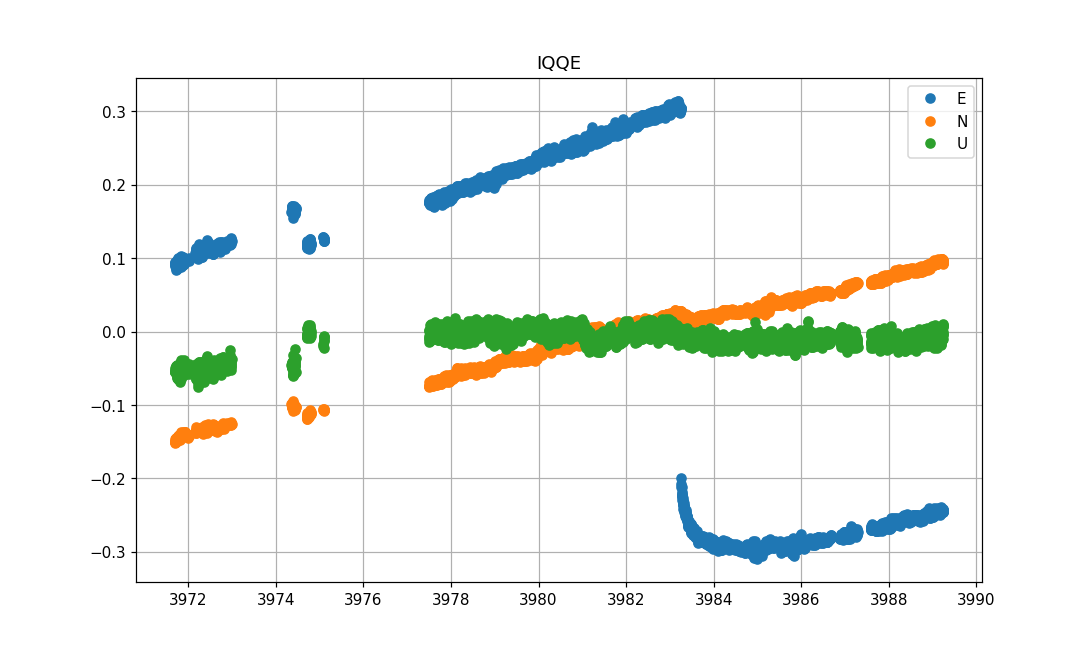

In [4]:
plt.figure(figsize=(10,6))
plt.plot_date(x,data[:,3],label='E')
plt.plot_date(x,data[:,4],label='N')
plt.plot_date(x,data[:,5],label='U')
plt.legend()
plt.title('IQQE')
plt.grid()

## Trimming the dataset so that we are dealing with data between 2009/01/01 - 2015/01/01

In [5]:
start_day,end_day = gen_jjj(2009,1,1),gen_jjj(2015,1,1)
data = data[(x>=start_day)*(x<=end_day),:]
x = x[(x>=start_day)*(x<=end_day)]


## Taking a look at the trimmed data

<IPython.core.display.Javascript object>


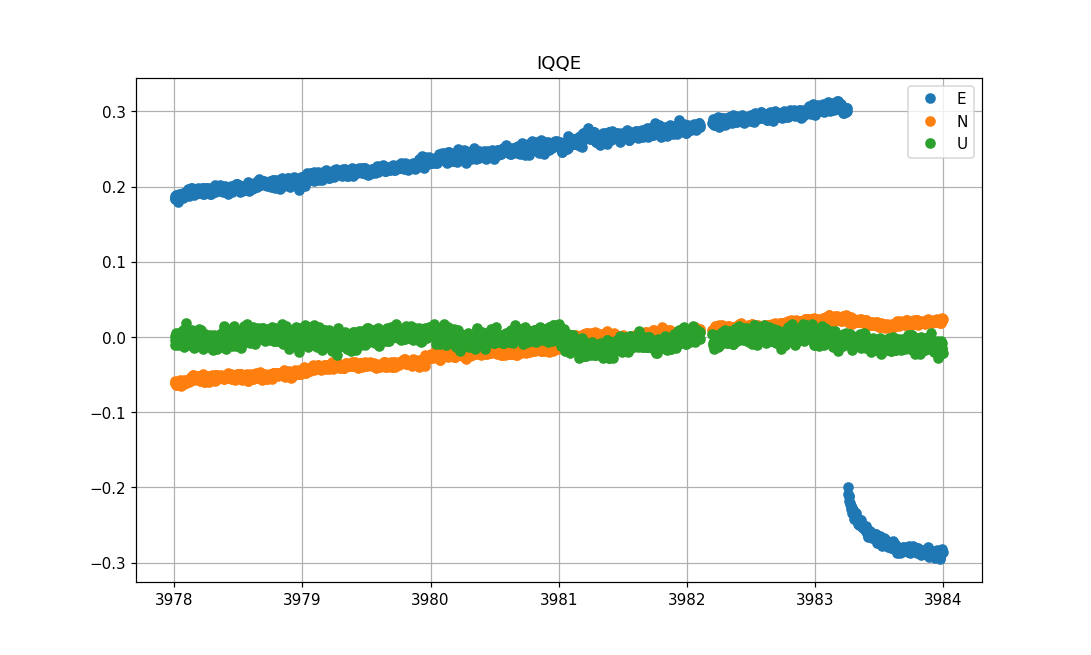

In [6]:
plt.figure(figsize=(10,6))
plt.plot_date(x,data[:,3],label='E')
plt.plot_date(x,data[:,4],label='N')
plt.plot_date(x,data[:,5],label='U')
plt.legend()
plt.title('IQQE')
plt.grid()

# Now running GrAtSiD

## Step (1):  generate the options (hyperparameters/settings)

In [7]:
options = generate_options()

In [8]:
options

{'max_gap': 30,
 'bigTs': array([0.001, 0.01 , 0.1  ]),
 'Fs': 1,
 'osc_periods': [365.25, 182.625],
 'polynomial_order': 1,
 'tik_mul': 1e-05,
 'TO_types': [0, 3],
 'n_search': 10,
 'max_remove': 2,
 'max_no_improvement_count': 1,
 'frac_remove': 0.5,
 'each_side': 3,
 'nsols': 5,
 'noise_flag': 1,
 'verbose': 0,
 'order_rooted_polynomial': 1,
 'fractional_tolerance': 0.02,
 'max_TOs': 15,
 'gradient_descent': False,
 'frac': 0.5,
 'S_each_side': 90,
 'max_its': 1000,
 'chances': 100,
 'min_frac_improvement': 0.01,
 'lrate': 0.01,
 'damp': 1e-09,
 'opt_name': 'Adam',
 'verbose_GD': False}

For explanation of each feature, look at the code for the function 'generate_options' inside of the 'common_functions.py' module.

## Step (2):  Vary the options from the defaults.

In [9]:
options['nsols'] = 10 # Number of solutions / number of convergences
options['fractional_tolerance'] = 0.01 # Solution must increase by this fraction
options['max_TOs'] = 15 # Max number of Transient Onsets
options['verbose'] = 1
options['TO_types'] = [0, 3]


options['gradient_descent'] = False ### If you want to vary interannual seasonal amplitude
options['frac'] = 0.5  ### This controls the upper bound of the weighting on each seasonal basis function.
                      #### if options['frac'] = 0.5, lower bound = 1, upper bound = 1.5
options['max_its'] = 400
options['chances'] = 50
options['lrate'] = 1e-2
options['damp'] = 1e-9
options['verbose_GD'] = False
options['S_each_side'] = 90

## Step (3): Running gratsid

You can specify the 'known_steps', or specify an empty list.  Run the option that you prefer.

In [10]:
use_known_steps = 1  ## make 0 if you want to run without the known steps (faster)

if known_steps_in.size>0:
    if len(known_steps_in.shape) == 1:
        known_steps_in = known_steps_in.reshape(1,4)
    x_steps = gen_jjj(known_steps_in[:,0].astype(int),
                      known_steps_in[:,1].astype(int),
                      known_steps_in[:,2].astype(int))
    known_steps = np.hstack([(x_steps-1)[:,None],known_steps_in[:,-1][:,None]])
else:
    known_steps = []

if use_known_steps == 0:
    known_steps = []

### An important note about "known_steps"

Steps are treated by GrAtSiD like other transient functions such as "multi-transients" or "rooted polynomials".  This means that the **onset time** of the transient is the **last sample before transient motion**.  Therefore, if there is a pure step in the time series occuring on January 10th 2018, you need to tel GrAtSiD that the step is rooted on January 9th 2018.  In the code above, you can see that the first column of the known_steps table (where the time indices for step onsets are stored) has 1 subtracted: *(x_steps-1)*.  

The second column is the fraction of the day that the step has occurred on.  Due to the typical processing flow of daily GNSS displacement time series (the type of data that GrAtSiD was originally developed for), an earthquake step will appear to be smeared over two days, depending on when in the day that earthquake occurred.  Therefore, for "non-pure"/"smeared" Heavisides used for the earthquake-related steps, we must also enter the UTC time of day that the earthquake occurred as a fraction (e.g. 0.25 if it occurred at 0600hrs, 0.75 if it occurred at 1800hrs).

## Finally ready to start curve-fitting

Now running gratsid using the function 'gratsid_fit'.  This function has the inputs:

gratsid_fit(x,y,err,known_steps,options)

- **x** => the time vector
- **y** => the data vector or matrix
- **err** => the error vector or matrix (corresponding to each data point).  If none, running without errors (faster)
- **known_steps** => file with the onset times and fractional smearing of the known steps (fractional smearing can occur when higher-frequency sampled time series are averaged in windows; for example GNSS daily positions are often produced by taking the mean position from 30s sampling-frequency time series).
- **options** => the options generated and edited in steps (1) and (2)


And so, running on a single component only:

In [11]:
y = data[:,4][:,None]  ## choosing a single component.  The [:,None] makes the y into a 2D array (better than 1D array for input into gratsid)

perm,sols,options_out = gratsid_fit(x,y,None,known_steps,options)

Misfit after initial fit: 0.18746030372269085
Misfit before comb.-analysis: 0.18746030372269085
Misfit after comb.-analysis: 0.12232757719038692
Misfit after swap-out: 0.12162239884103031
End of gratsid iteration,
# transients found:  1

Still searching solution  1  of  10
Misfit before comb.-analysis: 0.12162239884103031
Misfit after comb.-analysis: 0.11739520061974083
Misfit after swap-out: 0.11731182545207738
End of gratsid iteration,
# transients found:  2

Still searching solution  1  of  10
Misfit before comb.-analysis: 0.11731182545207738
Misfit after comb.-analysis: 0.11458605868650774
Misfit after swap-out: 0.1142469816073885
End of gratsid iteration,
# transients found:  2

Still searching solution  1  of  10
Misfit before comb.-analysis: 0.1142469816073885
Misfit after comb.-analysis: 0.11290489197792616
Misfit after swap-out: 0.11273932665254519
End of gratsid iteration,
# transients found:  3

Still searching solution  1  of  10
Misfit before comb.-analysis: 0.112739326652

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

**gratsid_fit** has 2 outputs.  In this case, I have called the outputs **perm** and **sols**, but you can call these whatever you like.

- **perm**  =>  A table containing the onset indices, function type, and additional parameter (depending on function type) for all PERMANENT basis functions

- **sols**  =>  A list that contains the SPARSE basis functions for each solution.

Taking a closer look at **perm**:

In [15]:
perm

NameError: name 'perm' is not defined

In **both perm** AND **sols**, the first column represents the onset index of the basis function (e.g. 0 corresponds to the 1st sample of the input time series, and so on...).  The second column corresponds to the function type.  In this version of gratsid, there are 4 function types:

- **0** => Heaviside step function (fractional smearing specified in 3rd column)
- **1** => Polynomial applied to the whole time series (order specified in 3rd column)
- **2** => Oscillation that is represented by sine and cosine functions (period given in the 3rd column)
- **3** => Muti-transient.  Third column is always 0.
- **4** => Rooted polynomial.  Instead of (or in addition to) multi-transients, gratsid can be told to find polynomials (of order n) that can begin at different times of the time series.  3rd column corresponds to the order of this polynomial.

Taking a close look at **sols**

In [ ]:
len(sols)

First of all, **sols** should be of length = options['nsols']
Each of these lists contains another list that contains the evolution of the transient (*sparse*) functions that were found by GrAtSiD in each iteration.

In [ ]:
sols[0]

The output of the cell above is many tables.  Each table represents the transient functions found by gratsid at each iteration of this solution.  From these tables, you could reconstruct the evolution of the fit for this particular solution (*convergence*).  Accordingly, it is the **final table that contains the converged solution**:

In [ ]:
sols[0][-1]

In output of the cell above, you can see the transient (*sparse*) basis functions for solution 1.

In [ ]:
if len(sols) > 1:
    sols[1][-1]

In output of the cell above, you can see the transient (*sparse*) basis functions for solution 2.

Note, at this point you will have noticed that the outputs of gratsid are simply tables.  The reason for this is to save disk space (if saving many solutions of long time series, for example).

These tables can be recombined with the *options* to construct the trajectory model.  This leads us to the next step...

## Step (4): Using the tables to see the (decomposed) trajectory models

To do this, we will run the function 'fit_decompose' which has the inputs:

fit_decompose(x,y,err,tik_mul,sols,perm_table,bigTs,Fs)

- **x** => the time vector
- **y** => the data vector or matrix
- **err** => the error vector or matrix (corresponding to each data point).  If none, running without errors (faster)
- **sols** => tables of solutions output by gratsid_fit function
- **perm** => table containing the information about 'permanent' basis function that is returned by the gratsid_fit function
- **options** => make sure to use the options ('options_out') returned by the gratsid_fit function.


So, here is how we run this function:

In [ ]:
signal = fit_decompose(x,y,None,sols,perm,options_out)

In [ ]:
len(signal)

You can see that the output (that we call here **signal**, but which can be called whatever you like) has a length of 6.  The first 5 lists correspond to the signal types (note that in Python we count from 0, and that these list indices correspond to the basis function types previously defined):

- **signal[0]** => Heaviside step functions 
- **signal[1]** => Polynomial applied to the whole time series
- **signal[2]** => Oscillations
- **signal[3]** => Muti-transients
- **signal[4]** => Rooted polynomials

The 6th list contains the residuals (input time series minus the full trajectory models):
- **signal[5]** => Residuals

Now, let's take a look at how these signal portions are arranged:

In [ ]:
type(signal[0])

As we see in output of above cell, each signal type contains a list...

In [ ]:
len(signal[0])

and the length of this list is the number of solutions (number of convergences = **options['nsols']**).

In [ ]:
signal[0][0].shape

Now, if we make each signal portion a Numpy array, we have a tensor of the following shape:

In [ ]:
np.array(signal[0]).shape

where the 1st dimension of this tensor is the number of solutions, 2nd dimension is number of samples in the time series, and 3rd dimension is the number of dimensions of the input data (1, in this simple example).

With these signal portions, you can reconstruct the trajectory models.  You have everything - all portions of the trajectory model and also the residuals.  Here are a few labelled examples

In [ ]:
np.array(signal[5][0])

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x,y,label='y')
for i in range(options['nsols']):
    plt.plot(x,y-np.array(signal[5][i]),'r')
    
plt.legend()
plt.title('Full trajectory models for all solutions')

In [ ]:
plt.figure()
plt.plot(x,y-np.nanmedian(np.array(signal[2]),axis=0),label='y - (median of oscillations)')
for i in range(options['nsols']):
    plt.plot(x,y-np.array(signal[5][i])-np.array(signal[2][i]),'r')
    
plt.legend()
plt.title('Trajectory models for all solutions (without seasonals)')

## If we are using gradient descent then we can look at the different solutions for the time weighted oscillations
#### Use the zoom function of the plotting window to check the extent of oscillation variation from year to year

In [ ]:
if options['gradient_descent'] == True:
    plt.figure();
    for i in range(options['nsols']):
        plt.plot(x,np.array(signal[2][i]),'b.')

    plt.grid()